## Advanced Dimensionality Reduction: PCA

#### Misael M. Morales

### Executive Summary
Subsurface spatial data is often very large and difficult to process and utilize in machine learning workflows. Moreover, there tends to be high degrees of correlation and structure in 2D subsurface data, which makes it a perfect candidate for latent structure analysis and modeling. 

Here, we will utilize a 2D multivariate subsurface dataset and demonstrate the usage of **Principal Component Analysis** to encode the data into the latent space and then reconstruct using a fraction of the original size. PCA works by performing an orthogonal transformation of the covariance matrix onto a set of linearly independent vectors, ordered by maximizing the variance explained in each successive orthogonal direction. We can then select the leading principal components to obtain a reduced-dimensionality representation of the data, and use this new feature speace to approximately reconstruct our images.

We learn that using PCA, different latent dimensions will result in different degrees of lossy reconstruction, but that this method is efficient, economic, and simple enough to treat our large data into a reduced dimensionality form. We recommend to use this autoencoder structure whenever dealing with image or volume problems in order to reduce redundancy and increase efficiency of our machine learning workflows.

### Table of Contents
1. Import Packages 
2. Declare Functions 
3. Load & Preprocess Data
        a) MNIST Data 
        b) Subsurface Data

4. Dimensionality Reduction: Principal Component Analsysis (PCA)

***

### 1. Import Packages

We start by importing our most basic packages:

In [1]:
%matplotlib inline
import numpy as np                     #arrays and matrix math
import pandas as pd                    #DataFrames management and indexing
import matplotlib.pyplot as plt        #plotting and visualization
import matplotlib.gridspec as gridspec #enhanced subplot referencing
import tensorflow as tf                #deep learning functionality and MNIST data

Import other important packages for preprocessing, metrics, etc., and project-specific packages and functions

In [2]:
# Feature Engineering/Preprocessing
from sklearn.preprocessing import StandardScaler              #Standardize variables to mean=0, var=1
from sklearn.preprocessing import MinMaxScaler                #Scale variables to min=0, max=1
from scipy.interpolate import Rbf as Rbf_interpolation        #Inteprolate 2D map from sparse data

# Goodness-of-Fit Metrics
from sklearn.metrics import mean_squared_error                #Mean squared error (MSE)
from skimage.metrics import structural_similarity as SSIM     #Structural Similarity Index (SSIM)

# Project-specific
from sklearn.decomposition import PCA                         #Principal Component Analysis (PCA)
from sklearn.decomposition import KernelPCA                   #Kernel Principal Component Analysis (kPCA)

### 2. Delcare Functions
The following functions will be used in the workflow.

In [3]:
# Plot function for sample images
def plot_sample_matrix(samples, my_cmap):
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig  = plt.figure(figsize=(axes, axes))
    gs   = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off'); ax.set_aspect('equal')
        plt.imshow(sample, cmap=my_cmap)

This variable will help us when inserting text boxes into our matplotlib plots

In [4]:
# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

This next function is optional, and will simply be a check that your current version of tensorflow on your Python kernel is running on a GPU and if tensorflow is built with CUDA.

In [5]:
# Check tensorflow GPU settings
print('Tensorflow built with CUDA? ',  tf.test.is_built_with_cuda())
tf.config.list_physical_devices()

Tensorflow built with CUDA?  False


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

### 3. Load & Preprocess Data

We will deal with two different datasets, both of which need preprocessing.

(1) MNIST dataset: handwritten digits as $28x28$ images from *tensorflow* </br>
(2) Subsurface multivariate data: 2D spatial (sparse) data

### 3. a) MNIST Data

This is a set of $60,000$ images of handwritten digits $0$-$9$. We load it directly from *tensorflow* datasets ([link](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist)), and will preprocess to center and flatten as needed for our techniques.

In [6]:
# Load the Dataset and split into train/test
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data()

# Choose to work with ALL or only a few (N) MNIST images (full size is 60,000)
#N = len(x_train_all)
N = 5000
x_train, x_test = x_train_all[:N], x_test_all[:N]
y_train, y_test = y_train_all[:N], y_test_all[:N]

# Normalize the Images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test  = np.expand_dims(x_test/255.0, axis=-1)

# Define the labels
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# Print the shapes of the training and testing sets + check that training images are normalized
print('MNIST dataset properties:')
print('Train || Shapes: X={}, Y={} | min={}, max={}'.format(x_train.shape, y_train.shape, x_train.min(), x_train.max()))
print('Test  || Shapes: X={}, Y={} | min={}, max={}'.format(x_test.shape, y_test.shape, x_test.min(), x_test.max()))

MNIST dataset properties:
Train || Shapes: X=(5000, 28, 28, 1), Y=(5000,) | min=0.0, max=1.0
Test  || Shapes: X=(5000, 28, 28, 1), Y=(5000,) | min=0.0, max=1.0


In [7]:
# Flatten and Center the images
print('Flattened and Center Images:')

# Flatten the images into NxM array
x_train_f = np.transpose(np.reshape(x_train, [x_train.shape[0], -1]))
x_test_f  = np.transpose(np.reshape(x_test, [x_test.shape[0], -1]))

# Center the Flattened images
x_train_f_c = x_train_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1)
x_test_f_c  = x_test_f - np.expand_dims(np.mean(x_test_f, axis=1), axis=1)

print('Train || Shapes: X={}, Y={} | min={:.3f}, max={:.3f}'.format(x_train_f_c.shape, y_train.shape, x_train_f_c.min(), x_train_f_c.max()))
print('Test  || Shapes: X={}, Y={} | min={:.3f}, max={:.3f}'.format(x_test_f_c.shape, y_test.shape, x_test_f_c.min(), x_test_f_c.max()))

Flattened and Center Images:
Train || Shapes: X=(784, 5000), Y=(5000,) | min=-0.549, max=1.000
Test  || Shapes: X=(784, 5000), Y=(5000,) | min=-0.531, max=1.000


For improved visualization, we will define a new colormap that uses the 10 individual digits ($0$-$9$) and implement the '*jet*' colormap.

In [8]:
# Define a colormap for the 10-class classification system
import matplotlib.cm as cm
from matplotlib.colors import Normalize
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs      = my_cmap(my_norm(y_train))

Next, we will count the number of items that is in each of the 10 digit categories, and also visualize the first few samples from the training and testing dataset.

In [9]:
# Count the number of occurrences for each digit within the training/testing datasets
digit_count = {}
for i in np.arange(len(class_names)):
    digit_count[i] = x_train[y_train==i].shape[0]
digit_count = pd.DataFrame(list(digit_count.values()), columns=['Count']).T
print('Count per Digit:')
digit_count.head()

Count per Digit:


,0,1,2,3,4,5,6,7,8,9
Count,479,563,488,493,535,434,501,550,462,495


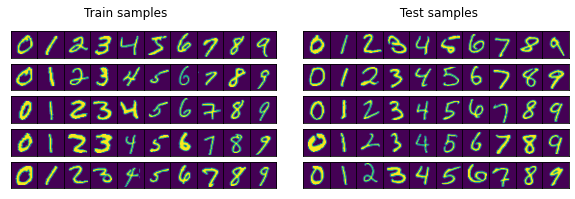

In [10]:
# Visualize a few Train/Test samples from mnist
fig = plt.figure(figsize=(10, 3), constrained_layout=False)
fig.suptitle('Train samples'+60*' '+'Test samples')
outer_grid = fig.add_gridspec(1, 2, wspace=0.1, hspace=0)

left_grid = outer_grid[0, 0].subgridspec(5, 10, wspace=0, hspace=0)
axs = left_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_train[y_train==d][c]); ax.set(xticks=[], yticks=[])
    
right_grid = outer_grid[0, 1].subgridspec(5, 10, wspace=0, hspace=0)
axs = right_grid.subplots() 
for (c,d), ax in np.ndenumerate(axs):
    ax.imshow(x_test[y_test==d][c]); ax.set(xticks=[], yticks=[])
    
plt.show();

### 3. b) Subsurface Data

The following workflow applies the .csv file 'spatial_nonlinear_MV_facies_v1.csv', a synthetic dataset calculated with geostatistical cosimulation by Dr. Michael Pyrcz, The University of Texas at Austin. The dataset is publically available [here](https://github.com/GeostatsGuy/GeoDataSets)  

From this site, other datasets can also be used for this workflow including but not limited to: {'spatial_nonlinear_MV_facies_v5.csv', 'sample_data_MV_biased.csv', 'PGE383_Dataset_13_Wells.csv', '12_sample_data.csv'}.

We will work with the following features:

* **X** and **Y** - the sptial coordinates (in meters) for the subsurface data
* **Porosity** - fraction of rock void in units of percentage
* **Permeability** - ability of a fluid to flow through the rock in milliDarcy
* **Acoustic Impedence** - product of sonic velocity and rock density (in $kg/m^2s*10^3$)
* **Facies** - binary indicator of sand or shale facies

In [11]:
# Select a subsurface Dataset for image reconstruction
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
df.head() #visualize first few rows of the DataFrame

,X,Y,Porosity,Perm,AI,Facies
0,1.219681,10.006391,7.791849,332.802662,4114.121592,1
1,1.400597,160.265186,16.708829,505.072608,3820.596087,1
2,15.497048,775.834642,12.430224,404.367985,4180.556194,1
3,15.642437,446.832057,5.269760,196.557726,5399.358427,0
4,15.873019,476.372378,5.662789,333.942714,4055.169132,1


We perform standardization of the features by applying Standard Scaler of the features such that:

$$ x^* = \frac{x-\bar{x}}{\sigma_x} $$

such that $x^*$ has zero mean $\bar{x^*}=0.0$ and unit variance $\sigma^2_{x^*}=1.0$ for each of the features in the dataset. Otherwise, the difference between the scale of the features would have significant impact on the covariance matrix calculation.

This is done by the *scikitlearn* built-in function
``` python
standard_scaler = sklearn.preprocessing.StandardScaler()
scaled_array    = standard_scaler.fit_transform(float_array)
```

In [12]:
scaler = StandardScaler()                   #instantiate the standardization function
df_s = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)  #apply standard scaling
df_s.describe().T                           #show summary statistics of the new DataFrame

,count,mean,std,min,25%,50%,75%,max
X,457.0,6.316367e-18,1.001096,-1.841830,-0.823436,0.123333,0.853587,1.569595
Y,457.0,-3.318522e-16,1.001096,-1.822462,-0.806696,0.040559,0.892515,1.686068
Porosity,457.0,2.055249e-16,1.001096,-2.206790,-0.759814,0.049673,0.655060,2.693817
Perm,457.0,-3.512872e-16,1.001096,-1.770773,-0.657275,0.035710,0.587008,3.479338
AI,457.0,1.621849e-15,1.001096,-1.472181,-0.682380,-0.237512,0.378880,4.549487
Facies,457.0,3.187336e-16,1.001096,-1.926484,0.519080,0.519080,0.519080,0.519080


For simplicity, we specifically name our subsurface features/properties.

We also specifically name the *matplotlib* colormaps that we want to use for each of the feautures/properties.

In [13]:
features = ['Porosity','Perm','AI','Facies']       # names of our features
my_maps  = ['magma', 'jet', 'seismic', 'viridis']  # names of the corresponding colormaps

However, this is a **sparse** dataset of the subsurface, with 457 wells in approximately $1 km^2$ area of the subsurface. Therefore, we must interpolate the spatial properties so that we obtain a full image of the subsurface properties. 

The 2D interpolation is done through *scipy*'s RBF interpolation function. This generates radial basis function inteprolation from $(N,D)$ arrays to an $(M,D)$ domain.

We will interpolate the subsurface 2D data into $(28,28)$ images. These are the standard dimensions of the MNIST dataset, a generic dataset of handwritten digits that we will use later for our workflow.

In [14]:
# Interpolate spatial properties
ti = np.linspace(start=0, stop=1, num=28) #an array of 28 discrete points
XI, YI = np.meshgrid(ti,ti)               #a mesh of 28x28 discrete points
ZI = {}; ZI_s = {}                    

for i in features:
    # RBF interpolation
    ZI[i] = Rbf_interpolation(df_s['X'], df_s['Y'], df[i], function='thin_plate')(XI, YI)[::-1]
    # Normalize our interpolated features 
    ZI_s[i]  = scaler.fit_transform(ZI[i])

for i in np.arange(len(features)):
    print('Standard '+features[i]+': Shape={}, mean={:.3f}, var={:.3f}'.format(ZI_s[features[i]].shape,
                                                                               ZI_s[features[i]].mean(), 
                                                                               ZI_s[features[i]].var()))

Standard Porosity: Shape=(28, 28), mean=0.000, var=1.000
Standard Perm: Shape=(28, 28), mean=0.000, var=1.000
Standard AI: Shape=(28, 28), mean=0.000, var=1.000
Standard Facies: Shape=(28, 28), mean=-0.000, var=1.000


Min-Max scale features for visualization and comparison of discrete data and interpolated features

In [15]:
#Min-Max scale original features
minmax_scaler = MinMaxScaler()                           #instantiate the min_max scaler function
df_mm = pd.DataFrame(minmax_scaler.fit_transform(df), columns=df.columns)  #apply min_max scaling

ZI_mm = {}
#Min-Max scale interpolated features
for i in features:
    ZI[i] = Rbf_interpolation(df_mm['X'], df_mm['Y'], df[i], function='thin_plate')(XI, YI)[::-1]
    ZI_mm[i] = minmax_scaler.fit_transform(ZI[i])

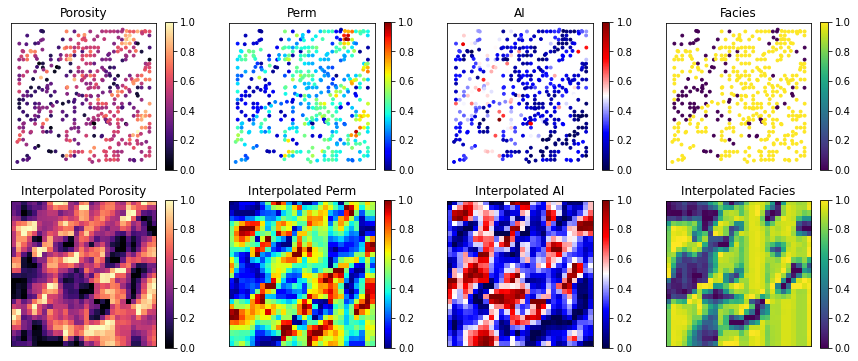

In [16]:
fig, axs = plt.subplots(2,4, figsize=(15,6))
for i in range(len(features)):
    axs[0,i].set_title(features[i]); axs[1,i].set_title('Interpolated '+features[i])
    # plot original data scatterplots
    im1 = axs[0,i].scatter(x=df_mm['X'], y=df_mm['Y'], vmin=0, vmax=1, s=8, c=df_mm[features[i]], cmap=my_maps[i])
    fig.colorbar(im1, ax=axs[0,i])
    # plot interpolated images
    im2 = axs[1,i].imshow(ZI_mm[features[i]], vmin=0, vmax=1, cmap=my_maps[i])
    fig.colorbar(im2, ax=axs[1,i])
    # remove ticks, set square box ratios
    for k in range(2):
        axs[k,i].set_xticks([]); axs[k,i].set_yticks([]); 
        axs[k,i].set_aspect('equal', adjustable='box')
plt.show();

Select one of the subsurface features to be used in the remainder of the notebook for image reconstruction.

In [17]:
# Select one of the subsruface features to work with
feature_selected = 'AI'

***

### 4. Advanced Dimensionality Reduction

Dimensionality Reduction is quite ubiqutuous in modern machine learning. PCA has been widely-studied and applied in theoretical and applied setting for data science, including reservoir characterization, modeling, and simulation. Through PCA, we can obtain an orthogonal transformation that maximally retains the variance of the features, and reduce the number of vectors to still "explain" majority of the information. With this, we can project our 2D data onto the vectors and work in latent space.

Another consideration is the idea of using the latent space for a generic dataset as the basis for reconstruction of a more complex dataset. For instance, using the PCA projection of the $60,000$ MNIST images, we can reconstruct our 2D subsurface maps from a latent represenation!

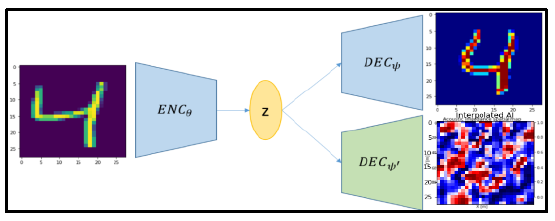

### 4. Principal Component Analysis (PCA)

We start by implementing PCA on our MNIST dataset to obtain principal component loadings and scores. PCA removes the mean and scales variance to unity before perfoming SVD on the correlation matrix, and the new coordinates determined by the PC's are uncorrelated but maximally explain variance. With this, we only select a subset such that we encode our matrices onto the latent space and work with a reduced dimensionality problem. Then we reconstruct our images from the inverse encoders using only $k$-dimensional latent vector, and analyze the results:

Principal Component Analysis can be described as follows:

First obtain the mean vector $\bar{x}$:
        $$ \bar{x_j}=\frac{1}{n}\sum\limits_{i=1}^{n}x_{ij} $$
     
Substract the mean from the data to obtain the centered matrix $B$ and compute the covariance matrix $C$:
        $$ B = X-\bar{X} $$
        $$ C = \frac{1}{n-1}B^TB $$
        
The first PC $u_1$ is the eigenvector of $B^TB$ corresponding to the largest eigenvalue, which maximizes the variance in the transformed coordinates $Bu_1$ such that:
        $$ u_1 = \underset{||u_1||=1}{\operatorname{argmax}}{u_1^TB^TBu_1} $$

And the $k$-th PC $u_k$ is obtained by substracting the first $k-1$ PCs from $B$ and maximizing the variance in the transformed coordinates $\hat{B_k}u_k$ such that:
        $$ \hat{B_k} = B - \sum\limits_{i=1}^{k-1}{Bu_iu_i^T} $$
        $$ u_k = \underset{||u_k||=1}{\operatorname{argmax}}{u_k^T\hat{B_k^T}\hat{B_k}u_k} = \operatorname{argmax}{\frac{u_k^T\hat{B_k^T}\hat{B_k}u_k}{u_k^Tu_k}} $$

We can also interpret PCA as the application of SVD to the covariance matrix. In general, we can construct an eigenvalue problem where each nonzero singular value of $X$ is a positive square root of an eigenvalue of $X^TX$ and $XX^T$. For instance, the correlation matrix $XX^T$ is formed by taking the inner product of the rows of $X$. Then, the columns of $V$ are eigenvectors of the correlation matrix $XX^T$ and the columns of $U$ the eigenvectors of the correlation matrix $X^TX$. These are hierarchically ordered by energy (variance explained) where $U$ contains column information of $X$ and $V$ contains row information of $X$.

Note that $k$ will fundamentally depend on the rank of the matrix $X$ such that $k\leq\min{(m,n)}$. For reconstruction using the latent space variables, it then follows that: $ \tilde{X}_{test} = \sum\limits_{i=1}^{k}\alpha_i\tilde{u}_i=\tilde{U}\alpha$, where $\alpha_i$ are the coefficients tht can be estimated to give the best MSE approximation. Then: 
$$ \tilde{U}^*x_{test} = \tilde{U}^*\tilde{U}\alpha=\alpha \Longrightarrow \tilde{x}_{test}=\tilde{U}\tilde{U}^*x_{test}$$

Here, we reduce the dimension of each of the MNIST images from $784$ to $k=n_{components}$.

In [18]:
# Perform Principal Component Analysis on our MNIST data (flat, centered)
n_components = 200
pca = PCA(n_components=n_components) 
pca.fit(x_train_f.T)

# Store principal components in a DataFrame
z_pca = pd.DataFrame(pca.transform(x_train_f.T), columns=['PCA%i' % i for i in range(n_components)])
print('PCA transform shape: {}'.format(z_pca.shape))

PCA transform shape: (5000, 200)


Variance explained by first 5 PCs: [0.099 0.074 0.061 0.054 0.047]
Total Variance explained by 200 PCAs: 0.968


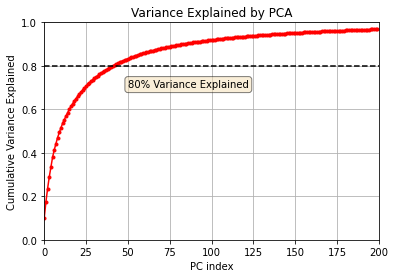

In [19]:
# Compute the variance explained by the first k principal components
print('Variance explained by first 5 PCs: {}'.format(np.round(pca.explained_variance_ratio_[:5],3)))
print('Total Variance explained by {} PCAs: {}'.format(n_components, 
                                                       np.round(pca.explained_variance_ratio_[:n_components].sum(),3)))  

plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum(), 'r.-')
plt.plot([0,n_components],[0.8,0.8], color='black',linestyle='dashed')
plt.text(50, 0.70, '80% Variance Explained', bbox=my_box)
plt.title('Variance Explained by PCA')
plt.xlabel('PC index'); plt.ylabel('Cumulative Variance Explained')
plt.grid('on'); plt.ylim([0,1]); plt.xlim([0,n_components])
plt.show();

We observe that with approximately 40 PCs we can explain about $80%$ of the variance in the MNIST dataset. Therefore, we will reduce the dimensionality of the problem from $(784,N)$ to $(40,N)$.

In [20]:
# Define how many principal components we want to keep
k = 40

pca = PCA(n_components = k)
pca.fit(x_train_f.T)

# Store principal components in a DataFrame
z_pca = pca.transform(x_train_f.T)
z_pca = pd.DataFrame(pca.transform(x_train_f.T), columns=['PCA%i' % i for i in range(k)])
print('PCA transform shape: {}'.format(z_pca.shape))

PCA transform shape: (5000, 40)


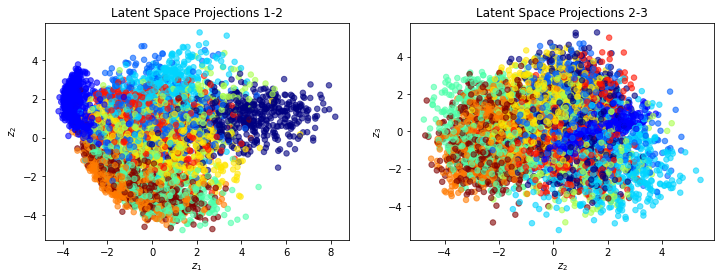

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(z_pca['PCA0'][:], z_pca['PCA1'][:], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_1$'); plt.ylabel('$z_2$'); plt.title('Latent Space Projections 1-2')
plt.subplot(1, 2, 2)
plt.scatter(z_pca['PCA1'][:], z_pca['PCA2'][:], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_2$'); plt.ylabel('$z_3$'); plt.title('Latent Space Projections 2-3')
plt.show();

In [22]:
# Compute the inverse transform onto the original dimension
x_train_f_hat = pca.inverse_transform(z_pca)
print('PCA Inverse transform shape: {}'.format(x_train_f_hat.shape))

# Reconstructed images using k basis
x_train_hat = np.reshape(x_train_f_hat, [-1, 28,28])
print('PCA Inverse transform images shape: {}'.format(x_train_hat.shape))

PCA Inverse transform shape: (5000, 784)
PCA Inverse transform images shape: (5000, 28, 28)


We now project our $60,000$ MNIST digits onto the principal components vectors to obtain our latent representations.

With this latent representation, we can now reconstruct into our predicted images using the first $k$ basis and projected back to form $\tilde{x}=\tilde{U}\tilde{U}^Tx$.

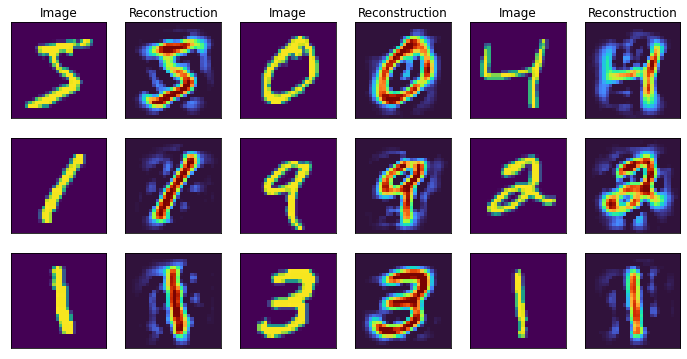

In [23]:
num_rows, num_cols = 3, 3
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train[i], vmin=0, vmax=1, cmap='viridis')
    if i < 3: plt.title('Image')
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train_hat[i], vmin=0, vmax=1, cmap='turbo')
    if i < 3: plt.title('Reconstruction')
plt.show();

We now have predicted images $\hat{x}$ for our MNIST dataset. Essentially, the decoded images from a truncated latent represenation obtained from PCA.

We will visualize these reconstructed images, and compare their quality by means of pixel-wise MSE and SSIM. Where:
    $$ MSE = \frac{1}{n} \sum\limits_{i=1}^{n}(y_i-\hat{y}_i)^2$$
and
    $$ SSIM(x,y) = \frac{(2\mu_x\mu_y+c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2+\mu_y^2+c_1)(\sigma^2_x+\sigma^2_y+c_2)}$$
where $y_i$ are the true images and $\hat{y}_i$ are the reconstructed images for the MSE computation. On the other hand, we have that for SSIM, $x$ and $y$ are the two images to be compared, and $c_1 = (k_1L)^2$ and $c_2=(k_2L)^2$ are two variables to stabilize the division with weak denominators. Usually, $k_1=0.01$ and $k_2=0.03$, and $L=2^{(\#bits/pixel)}-1$ typically.

For MSE calculation, we will use the flattened, centered arrays $N \times M$ as opposed to the images $N \times (M,D)$ used in the SSIM calculation.

In [24]:
# Error Metrics for selected level of k
mse  = mean_squared_error(x_train_f.T, x_train_f_hat)
ssim = SSIM(x_train.squeeze(), x_train_hat)
print('MSE={:.3f} | SSIM={:.3f}'.format(mse,ssim))

MSE=0.014 | SSIM=0.868


A really low MSE and high SSIM! That is great considering we only kept $k$ principal components from our original data!

**Kernel PCA (kPCA)**

This extension of PCA allows for non-linear dimensionality reduction through the usage of kernel functions. Normally, PCA assumes a linear relationship between features, and will find the (eigen)vector that maximizes the variance in the data, recursively. However, for non-linear relationships we require non-linear kernel functions that will still maximize the variance without linearity constraints. This allows us to apply PCA techniques to systems with non-linear or unknown, complex physics.

Using the *linear* kernel would result in similar performance to the regular PCA implementation. Therefore, the user can choose between *linear*, *poly*, *rbf*, *sigmoid*, *cosine*, or a *precomputed* kernel.

In [25]:
kpca = KernelPCA(n_components=k, fit_inverse_transform=True, kernel='poly', degree=9)
kpca.fit(x_train_f.T)

KernelPCA(degree=9, fit_inverse_transform=True, kernel='poly', n_components=40)

In [26]:
# Store principal components in a DataFrame
z_kpca = kpca.transform(x_train_f.T)
z_kpca = pd.DataFrame(kpca.transform(x_train_f.T), columns=['PCA%i' % i for i in range(k)])
print('PCA transform shape: {}'.format(z_kpca.shape))

# Compute the inverse transform onto the original dimension
x_train_f_hat = kpca.inverse_transform(z_kpca)
print('kPCA Inverse transform shape: {}'.format(x_train_f_hat.shape))

# Reconstructed images using k basis
x_train_hat = np.reshape(x_train_f_hat, [-1, 28,28])
print('kPCA Inverse transform images shape: {}'.format(x_train_hat.shape))

PCA transform shape: (5000, 40)
kPCA Inverse transform shape: (5000, 784)
kPCA Inverse transform images shape: (5000, 28, 28)


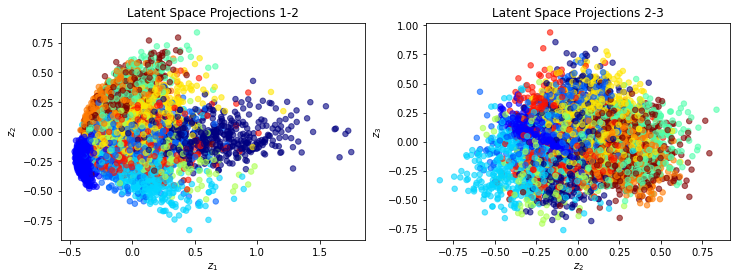

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(z_kpca['PCA0'][:], z_kpca['PCA1'][:], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_1$'); plt.ylabel('$z_2$'); plt.title('Latent Space Projections 1-2')
plt.subplot(1, 2, 2)
plt.scatter(z_kpca['PCA1'][:], z_kpca['PCA2'][:], s=30, c=cs, alpha=0.6)
plt.xlabel('$z_2$'); plt.ylabel('$z_3$'); plt.title('Latent Space Projections 2-3')
plt.show();

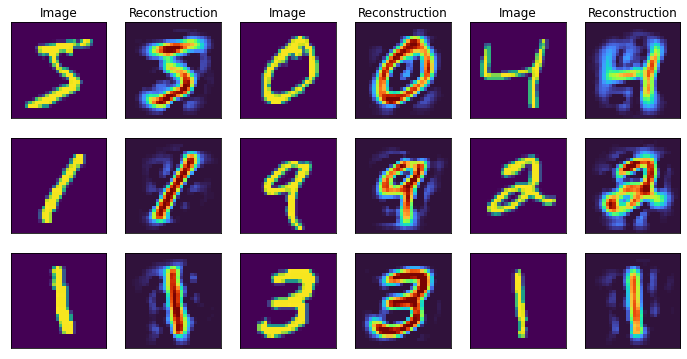

In [28]:
num_rows, num_cols = 3, 3
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_rows*num_cols):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train[i], vmin=0, vmax=1, cmap='viridis')
    if i < 3: plt.title('Image')
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(x_train_hat[i], vmin=0, vmax=1, cmap='turbo')
    if i < 3: plt.title('Reconstruction')
plt.show();

In [29]:
# Error Metrics for selected level of k
mse  = mean_squared_error(x_train_f.T, x_train_f_hat)
ssim = SSIM(x_train.squeeze(), x_train_hat)
print('MSE={:.3f} | SSIM={:.3f}'.format(mse,ssim))

MSE=0.013 | SSIM=0.876


***

**Subsurface PCA:**

Next, we will use those $k$ principal components loadings and scores comptued from the PCA decomposition of MNIST, and project our $28x28$ subsurface maps onto them. After projection, we will decode the latent variables using the same structure as before and obtain new reconstructions from the reduced-dimensionality maps.

Image shape: (784, 1)


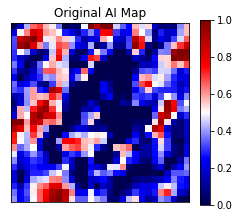

In [30]:
A_gsc_r_f   = np.reshape(ZI_mm[feature_selected], (28*28, 1))                   #flatten
A_gsc_r_f_c = A_gsc_r_f - np.expand_dims(np.mean(x_train_f, axis=1), axis=1)    #center
print('Image shape:', A_gsc_r_f_c.shape)

# Plot the processed 2D map
plt.figure(figsize=(4, 4))
plt.imshow(np.reshape(A_gsc_r_f_c, (28, 28)), vmin=0, vmax=1,
           cmap=my_maps[features.index(feature_selected)])
plt.title('Original '+feature_selected+' Map'); plt.xticks([]); plt.yticks([])
plt.colorbar(shrink=0.85)
plt.show();

Try reconstructing the image from the latent variable of MNIST to a full 2D subsurface reservoir property map using a few different $k$'s, where $k$ is the size of the latent vector.

Note that we project our image *A_gsc_r_f_c* onto the precomputed principal component loadings and vectors of the MNIST matrix. This is projecting our image onto the generic latent space $z_{MNIST}$.

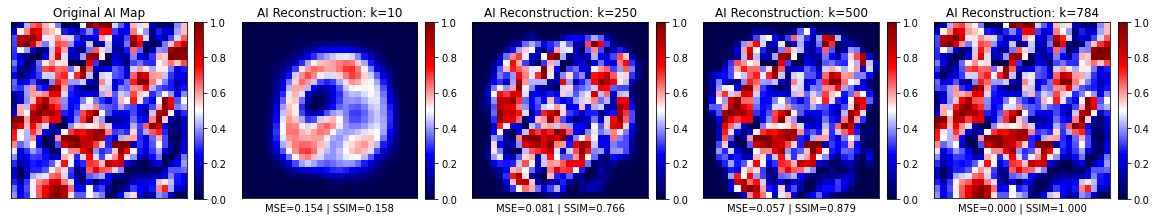

In [31]:
ks = [10, 250, 500, 784]

plt.figure(figsize=(len(ks)*5,4))

plt.subplot(1,len(ks)+1,1)
plt.imshow(ZI_mm[feature_selected], cmap=my_maps[features.index(feature_selected)])
plt.title('Original '+feature_selected+' Map')
plt.colorbar(fraction=0.046, pad=0.04); plt.xticks([]); plt.yticks([])

for i in np.arange(len(ks)):
    #project image onto latent space
    pca = PCA(n_components = ks[i])
    pca.fit(x_train_f.T)
    U_pca = pca.components_ @ A_gsc_r_f_c
    
    A_gsc_r_f_c_hat = (U_pca.T @ pca.components_).T
    A_gsc_r_f_hat   = A_gsc_r_f_c_hat + np.expand_dims(np.mean(x_train_f, axis=1), axis=1)
    A_gsc_r_hat     = np.reshape(A_gsc_r_f_hat.T, [-1, 28, 28])
    
    mse  = mean_squared_error(A_gsc_r_f_c, A_gsc_r_f_c_hat)
    ssim = SSIM(ZI_mm[feature_selected], A_gsc_r_hat.squeeze())

    plt.subplot(1,len(ks)+1,i+2)
    img = plt.imshow(np.squeeze(A_gsc_r_hat), vmin=0, vmax=1,
                     cmap=my_maps[features.index(feature_selected)])
    plt.title(feature_selected+' Reconstruction: k='+ str(ks[i]))
    plt.xlabel('MSE={:.3f} | SSIM={:.3f}'.format(mse, ssim))
    plt.colorbar(fraction=0.046, pad=0.04); plt.xticks([]); plt.yticks([])
    
plt.show();

We can see that using only $k=10$ bases, we obtain basically approximately a digit $0$, corresponding to our MNIST latent space representation! Using too few (unrelated/generic) bases will give us a bad reconstruction.

However, we obtain really good MSE and SSIM for the reconstructions when using just about half the dimension for the bases of the principal components. We get (almost) perfect reconstruction when we use (almost) all of the bases.

If we were to apply PCA to the subsurface image itself and then reconstruct it using a few of its own bases (like we did previously with the MNIST example), then we would obtain a great reconstruction with very few tailored bases. This example however shows the power of using a pre-trained decomposition matrix on a new subsurface image to reconstruct with small errors and low computational costs (i.e., transfer learning).

***

### Results and Discussion

PCA:
- PCA is very widely-used and can be applied to a large set of problems in science and engineering, including 2D/3D problems such as subsurface images/volumnes, and dynamic problems such as reservoir simulation. It has been used to find parameterization, clustering and inference, and of course dimensionality reduction.
- PCA can be dervied mathematically from the formulation of SVD decomposition of the centered covariance matrix and truncating less important basis vectors.
- The kernel PCA (kPCA) implementation allows for non-linear dimensionality reduction through the usage of kernel functions. We can use this for a large-scale problem with nonlinear physics without the full computational effort of physical simulation, and it is very useful for a wide set of applicaitons.

Important Notes:
- The MNIST dataset has the digits centered at the image. Therefore, we using the learned basis from this generic dataset, our subsurface image reconstructions will be most accurate near the center and quite bad near the edges. If we increase the dimension of the latent space, we start to gather information of the edges (which is irrelevant for MNIST but relevant for subsurface maps). Therefore, for this particular transfer learning problem, we might need to use more latent variables than desired. Using a different generic dataset with more information near the edges to learn the sparse encoding might help in transfer reconstruction.

MNIST:
- Using PCA, we see that approximately 40 latent variables will suffice to encode the MNIST images (28x28=784) with 80% of the energy conserved. Alternatively, 95% energy would require approximately 150 latent variables. Nonetheless, for MNIST compression and reconstruction, our experiment shows that 40 latent variables are sufficient to obtain a very good MNIST reconstruction, with approximately MSE=0.014 and SSIM=0.868! 

Subsurface:
- With PCA we obtained a set of principal component loadings and scores, all from our training MNIST images. Using a subset of these vectors, we then projected our subsurface image onto it, thus reducing the dimensionality. Using the inverse decomposition we could then reconstruct this compressed subsuface image, and saw that using only 10 singular values our SSIM was about 0.16, using 250 singular values our SSIM was 0.76, and using 500 singular values our SSIM was 0.88. Using all singular values (k=784), our SSIM was 1.00. Therefore, we can say that transfer learning with extreme dimensionality reduction using PCA is not so good for reconstruction, and we actually need to maintain a large number of singular values to actually obtain a good result. Nonetheless, computational complexity and costs are really low for this technique.

Conclusions:
- Singular Value Decomposition is a very powerful and useful techniques for dimensionality reduction and image compression/reconstruction problems. They can also be used for other latent space applications such as clustering, parameter estimation, and more.

- MSE and SSIM provide useful measures for the goodness-of-fit and validity of our reconstructions. SSIM is especially useful when dealing with image datasets, and compares the mean and variance of a set of prior and posterior images. We see that for our experiment, MSE is low and SSIM is high when we try to reconstruct MNIST images from a latent dimension using MNIST basis, but we see medium MSE and SSIM (acceptable but not excellent) when reconstructing subsurface images from MNIST basis.

### References:
1. H.X. Vo and L.J. Durlofsky. "Data assimilation and uncertainty assessment for complex geological models using a new PCA-based parameterization." Comput. Geosci. 19 (2015): 747–767. doi: 10.1007/s10596-015-9483-x
2. A.A. Emerick. "Investigation on principal component analysis parameterizations for history matching channelized facies models with ensemble-based data assimilation." Math. Geosci. 49 (2017): 85-120. doi: 10.1007/s11004-016-9659-5.
3. J. He, P. Sarma, L.J. Durlofsky. "Reduced-order flow modeling and geological paramterization for ensemble-based data assimilation". Comput. Geosci. 55 (2013): 54-69. doi: 10.1016/j.cageo.2012.03.027
4. X. Ma and N. Zabaras, "Kernel principal component analysis for stochastic input model generation," J. Comput. Physics, 230 (2011): pp. 7311-7331. doi: 10.1016/j/jcp.2011.05.037

5. Brunton, S., & Kutz, J. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control. Cambridge: Cambridge University Press.
6. Murphy, K. P. (2012). Machine Learning: A Probabilistic Perspective. United States: MIT Press.
7. Phillips, J. M. (2021). Mathematical Foundations for Data Analysis. Germany: Springer International Publishing.
8. Verleysen, M., Lee, J. A., Lee, J. A. (2007). Nonlinear Dimensionality Reduction. Netherlands: Springer New York.
9. Wang, J. (2012). Geometric Structure of High-Dimensional Data and Dimensionality Reduction. Germany: Higher Education Press.
10. Pyrcz, M. J., Deutsch, C. V. (2014). Geostatistical Reservoir Modeling. United Kingdom: Oxford University Press.

***

### About Me

I am currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin, and I am supervised by Drs. Pyrcz and Torres-Verdin. My background is in Petroleum Engineering & Applied Mathematics from the University of Tulsa. I am originally from Venezuela!

At UT, I am working on the computational description of subsurface energy and environmental systems. I combine domain-specific knowledge with tools from machine learning & deep learning, math and statistics, for accurate characterization and forecasting of complex dynamical systems in the subsurface. My work is centered on integrated applied energy data analytics by developing novel technologies, practical workflows, demos and documentation to support the digital revolution in energy. My focus is on machine learning and data science applications for subsurface modeling and simulation, including: uncertainty quantification, inverse modeling, data assimilation, control & optimization, and physics-informed predictive analytics.


* More workflows to come on other advanced dimensionality reduction techniques!
    * PCA/kPCA, SVD, Dictionary Learning, tSNE, DFT/DCT/DWT, POD/DMD, Deep Learning-based AutoEncoders, ... 
* Also working on subsurface problems including machine learning & data science applications for reservoir modeling & simulation.
    * Uncertainty quantification, data assimilation, control & optimizaiton, inverse & reduced-order modeling! 

I hope this was helpful,

**Misael M. Morales**
#### [GitHub](https://github.com/misaelmmorales) | [Website](https://sites.google.com/view/misaelmmorales) | [LinkedIn](https://www.linkedin.com/in/misaelmmorales)

# END